# BERT Model

In [1]:
#Imports
import pandas as pd
import numpy as np

from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

from keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, concatenate, Bidirectional, GRU
from keras.models import Model
from keras.constraints import MaxNorm
from keras.optimizers import Adam

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score

##### 1)Loading Dataset

In [2]:
df=pd.read_csv("df_Original.csv")
df.head()

,tweet_id,label,text,length,preprocessed_abstract,length_after_cleaning,tokenized_text
0,570306133677760513,2,@VirginAmerica What @dhepburn said.,35,what say,8,"['what', 'say']"
1,570301130888122368,1,@VirginAmerica plus you've added commercials t...,72,plus add commercial experience tacky,36,"['plus', 'add', 'commercial', 'experience', 't..."
2,570301083672813571,2,@VirginAmerica I didn't today... Must mean I n...,71,i today must mean i need take another trip,42,"['i', 'today', 'must', 'mean', 'i', 'need', 't..."
3,570301031407624196,0,@VirginAmerica it's really aggressive to blast...,126,really aggressive blast obnoxious entertainmen...,78,"['really', 'aggressive', 'blast', 'obnoxious',..."
4,570300817074462722,0,@VirginAmerica and it's a really big bad thing...,55,really big bad thing,20,"['really', 'big', 'bad', 'thing']"


In [3]:
df.isnull().sum()

tweet_id                  0
label                     0
text                      0
length                    0
preprocessed_abstract    17
length_after_cleaning     0
tokenized_text            0
dtype: int64

In [4]:
df = df.dropna()

##### 2)Preparing Data

#####  3) Split , into Training and Validation Sets (80:20)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df['preprocessed_abstract'], df['label'], test_size=0.2, stratify=df['label'], random_state=42)
print("Train data:",  X_train.shape, y_train.shape)
print("Test data:",  X_test.shape, y_test.shape)

Train data: (11698,) (11698,)
Test data: (2925,) (2925,)


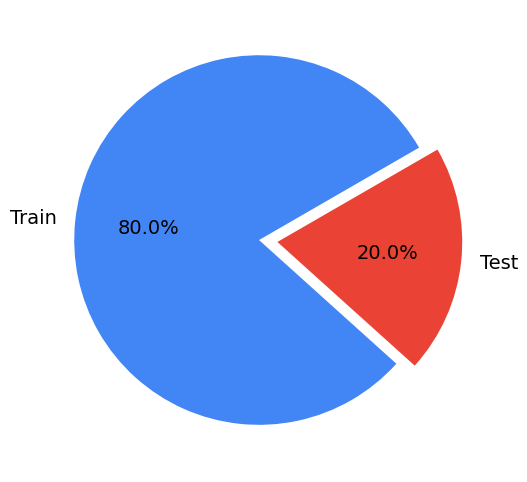

In [8]:
plt.figure(figsize=(14,6))
colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
plt.rcParams.update({'font.size': 14})
plt.pie([len(y_train), len(y_test)],
        labels=['Train','Test'],
        colors=colors, autopct='%.1f%%', explode=(0.05,0.05),
        startangle=30);

In [11]:
from transformers import TFAutoModel, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
inputs = tokenizer(X_train.tolist(), padding = True, truncation = True, return_tensors = 'tf')
inputs

import tensorflow as tf

output = tf.convert_to_tensor(y_train, dtype=tf.int64)
output

input_ids = inputs["input_ids"]
attention_mask = inputs["attention_mask"]
segment_ids = inputs.get("token_type_ids", None)

# Step 3: Convert to TensorFlow tensors
input_ids = tf.convert_to_tensor(input_ids)
attention_mask = tf.convert_to_tensor(attention_mask)
segment_ids = tf.convert_to_tensor(segment_ids) if segment_ids is not None else None


# Step 5: Create a dictionary of input tensors
input_dict = {
    "input_ids": input_ids,
    "attention_mask": attention_mask,
    "token_type_ids": segment_ids  # Include this if your BERT model expects segment_ids
}
inputstest = tokenizer(X_test.tolist(), padding = True, truncation = True, return_tensors = 'tf')


input_idstest = inputstest["input_ids"]
attention_masktest = inputstest["attention_mask"]
segment_idstest = inputstest.get("token_type_ids", None)

# Step 3: Convert to TensorFlow tensors
input_idstest = tf.convert_to_tensor(input_idstest)
attention_masktest = tf.convert_to_tensor(attention_masktest)
segment_idstest = tf.convert_to_tensor(segment_idstest) if segment_idstest is not None else None


# Step 5: Create a dictionary of input tensors
input_dicttest = {
    "input_ids": input_idstest,
    "attention_mask": attention_masktest,
    "token_type_ids": segment_idstest  # Include this if your BERT model expects segment_ids
}


outputtest = tf.convert_to_tensor(y_test, dtype=tf.int64)
outputtest

<tf.Tensor: shape=(2925,), dtype=int64, numpy=array([0, 0, 0, ..., 0, 0, 0])>

##### 4)Model Architecture

In [12]:
class BERTForClassification(tf.keras.Model):
  def __init__(self, bert_model, num_classes):
      super().__init__()
      self.bert = bert_model
      self.fc = tf.keras.layers.Dense(num_classes, activation = "softmax")
  def call(self, inputs):
    x = self.bert(inputs)[1]
    return self.fc(x)


model = TFAutoModel.from_pretrained("bert-base-uncased")

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [13]:
classifier = BERTForClassification(model, num_classes = 3)

In [15]:
classifier.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics = ["accuracy"]
)

##### 5) Training Model

In [16]:
history  = classifier.fit(input_dict, output, epochs = 5, validation_data = (input_dicttest, outputtest))

Epoch 1/5
366/366 [==============================] - 149s 283ms/step - loss: 0.6397 - accuracy: 0.7370 - val_loss: 0.5020 - val_accuracy: 0.7973
Epoch 2/5
366/366 [==============================] - 95s 260ms/step - loss: 0.4424 - accuracy: 0.8246 - val_loss: 0.4960 - val_accuracy: 0.7945
Epoch 3/5
366/366 [==============================] - 98s 267ms/step - loss: 0.3420 - accuracy: 0.8698 - val_loss: 0.5239 - val_accuracy: 0.8024
Epoch 4/5
366/366 [==============================] - 98s 266ms/step - loss: 0.2431 - accuracy: 0.9127 - val_loss: 0.5842 - val_accuracy: 0.7925
Epoch 5/5
366/366 [==============================] - 98s 267ms/step - loss: 0.1647 - accuracy: 0.9418 - val_loss: 0.6953 - val_accuracy: 0.7979


##### 6) Finding Training and Testing Accuracy

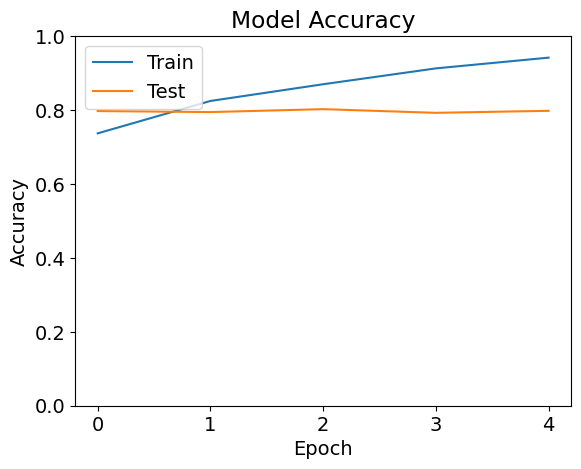

In [18]:
# Plot the training and testing accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim([0, 1])
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [19]:
test_loss,test_acc=classifier.evaluate(input_dicttest, outputtest)
test_loss,test_acc

92/92 [==============================] - 8s 81ms/step - loss: 0.6953 - accuracy: 0.7979


(0.6953032612800598, 0.7979487180709839)

##### 7) Compute and plot the confusion matrix for the three classes

In [20]:
predictions=classifier.predict(input_dicttest)
class_labels = ['negative', 'positive','neutral']
predicted_class_labels = [class_labels[np.argmax(pred)] for pred in predictions]
actual_class_labels=[class_labels[actual] for actual in y_test]
print(classification_report(actual_class_labels, predicted_class_labels))

92/92 [==============================] - 11s 84ms/step
              precision    recall  f1-score   support

    negative       0.83      0.92      0.87      1835
     neutral       0.70      0.49      0.58       617
    positive       0.74      0.73      0.74       473

    accuracy                           0.80      2925
   macro avg       0.76      0.71      0.73      2925
weighted avg       0.79      0.80      0.79      2925



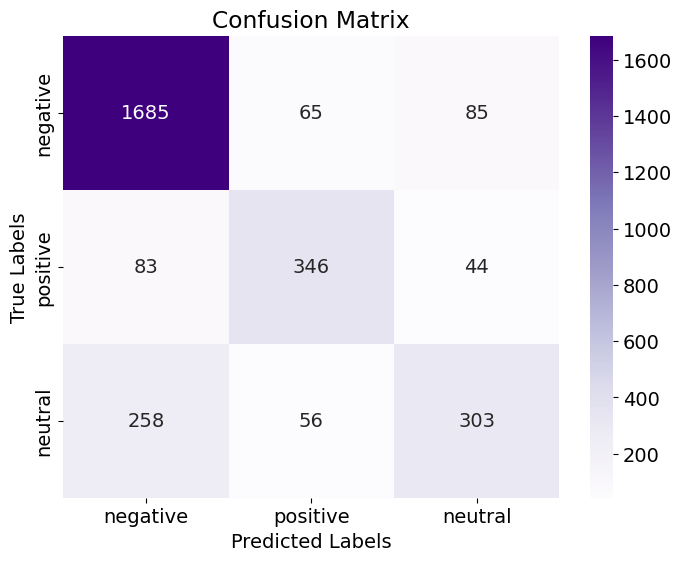

In [21]:
conf_matrix = confusion_matrix(actual_class_labels, predicted_class_labels, labels=class_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Purples", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

##### 8) Saving the final results in Excel sheet

In [22]:
precision_per_class = precision_score(actual_class_labels, predicted_class_labels, average=None)
recall_per_class = recall_score(actual_class_labels, predicted_class_labels, average=None)

print("Precision per class:", precision_per_class)
print("Recall per class:", recall_per_class)

Precision per class: [0.83168806 0.70138889 0.74089936]
Recall per class: [0.91825613 0.4910859  0.73150106]


In [23]:
f1_micro = f1_score(actual_class_labels, predicted_class_labels, average='micro')
f1_macro = f1_score(actual_class_labels, predicted_class_labels, average='macro')

print("Micro F1 Score:", f1_micro)
print("Macro F1 Score:", f1_macro)

Micro F1 Score: 0.7979487179487179
Macro F1 Score: 0.7288980421960836


In [24]:
data={'Original_Dataset':[max(history.history['accuracy']),test_acc,f1_micro,f1_macro,precision_per_class[0],precision_per_class[1],precision_per_class[2],recall_per_class[0],recall_per_class[1],recall_per_class[2]]}
result=pd.DataFrame(data,index=['Training Accuracy','Testing Accuracy','Micro F1 Score','Macro F1 Score','Precision for Negative sentiment','Precision for Positive sentiment','Precision for Neutral sentiment','Recall for Negative sentiment','Recall for Positive sentiment','Recall for Neutral sentiment'])
result

,Original_Dataset
Training Accuracy,0.941785
Testing Accuracy,0.797949
Micro F1 Score,0.797949
Macro F1 Score,0.728898
Precision for Negative sentiment,0.831688
Precision for Positive sentiment,0.701389
Precision for Neutral sentiment,0.740899
Recall for Negative sentiment,0.918256
Recall for Positive sentiment,0.491086
Recall for Neutral sentiment,0.731501


In [26]:
result.to_csv('BERT_ModelResults.csv', index=True)